In [39]:
# 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import re
from nltk.corpus import stopwords
from nltk import pos_tag # 품사 분류
from nltk.tokenize import word_tokenize # 단어 토큰화
from nltk.stem import WordNetLemmatizer
from collections import Counter

import platform
import sys
import os
MODULE_PATH = '/Users/anhyojun/VSCode/K-Digital Training/MyModule'
sys.path.append(MODULE_PATH)
from KDTModule import *

import nltk
# nltk.download('stopwords') # 불용어 목록 다운로드 해야 함
# nltk.download('punkt') # 토큰화 할때 필요
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')

In [40]:
# 시드 설정
torch.manual_seed(1)

In [41]:
# 데이터 불러오기
PATH = 'twitter/Twitter_Data.csv'
twitter = pd.read_csv(PATH)
print(f'Data Shape : {twitter.shape}')
twitter.head()

Data Shape : (162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [42]:
# 데이터 프레임 정보 확인
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [43]:
# 결측치 확인
twitter.isna().sum()

clean_text    4
category      7
dtype: int64

In [44]:
# 결측치 제거
twitter.dropna(inplace = True)
twitter.reset_index(drop=True, inplace=True)
twitter.isna().sum()

clean_text    0
category      0
dtype: int64

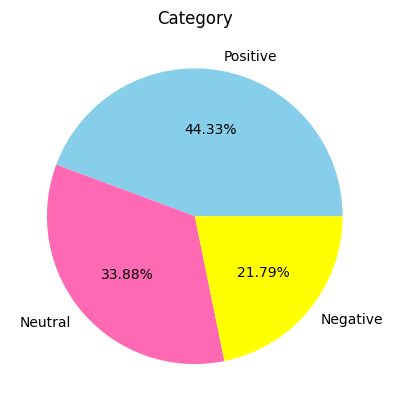

In [45]:
# 타겟 레이블 비율 시각화
plt.pie(twitter['category'].value_counts(), labels = ['Positive', 'Neutral', 'Negative'],
        autopct = '%.2f%%', colors = ['skyblue', 'hotpink', 'yellow'])
plt.title('Category')
plt.show()

> 긍정 : 44.33%, 중립 : 33.88%, 부정 : 21.79%

In [46]:
# 타겟 레이블 범주 (0, 1, 2)로 바꾸기
twitter['category'] = twitter['category'].replace(-1, 2)
twitter # 0: 중립, 1: 긍정, 2: 부정

,clean_text,category
0,when modi promised “minimum government maximum...,2.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162964,why these 456 crores paid neerav modi not reco...,2.0
162965,dear rss terrorist payal gawar what about modi...,2.0
162966,did you cover her interaction forum where she ...,0.0
162967,there big project came into india modi dream p...,0.0


In [47]:
# 불용어 및 특수문자 제거
stop_words = set(stopwords.words('english'))
total_text_list = []
for i in twitter['clean_text']:
    i = re.sub(r'[^A-Za-z0-9\s]', '', i)
    word_list = []
    for j in word_tokenize(i):
        if j not in stop_words:
            word_list.append(j)
    final_string = ' '.join(word_list)
    total_text_list.append(final_string)

In [48]:
twitter['clean_text'] = total_text_list
twitter

,clean_text,category
0,modi promised minimum government maximum gover...,2.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporters prefix chowkidar names modi ...,1.0
4,answer among powerful world leader today trump...,1.0
...,...,...
162964,456 crores paid neerav modi recovered congress...,2.0
162965,dear rss terrorist payal gawar modi killing 10...,2.0
162966,cover interaction forum left,0.0
162967,big project came india modi dream project happ...,0.0


In [49]:
# 단어를 단수화하는 객체
lemmatizer = WordNetLemmatizer()

# 복수형, 과거형 등 모두 단수형으로 변환
total_wordnet_list = []
for i in twitter['clean_text']:
    final_word_list = []
    pos_tag_list = pos_tag(word_tokenize(i))
    for word, pos in pos_tag_list:
        if pos[0] == 'N': final_word_list.append(lemmatizer.lemmatize(word, 'n'))
        elif pos[0] == 'J': final_word_list.append(lemmatizer.lemmatize(word, 'a'))
        elif pos[0] == 'R': final_word_list.append(lemmatizer.lemmatize(word, 'r'))
        elif pos[0] == 'V': final_word_list.append(lemmatizer.lemmatize(word, 'v'))
    total_wordnet_list.append(' '.join(final_word_list))

In [50]:
twitter['clean_text'] = total_wordnet_list
twitter

,clean_text,category
0,modi promise minimum government maximum govern...,2.0
1,talk nonsense continue drama vote modi,0.0
2,say vote welcome bjp tell rahul main campaigne...,1.0
3,ask supporter prefix chowkidar name modi great...,1.0
4,answer powerful world leader today trump putin...,1.0
...,...,...
162964,crore pay neerav modi recover congress leader ...,2.0
162965,dear rss terrorist payal gawar modi kill musli...,2.0
162966,cover interaction forum leave,0.0
162967,big project come india modi dream project happ...,0.0


In [51]:
# 각 문장별 명사, 형용사, 부사, 동사의 빈도수 세기
total_pos_dict_list = []
for i in twitter['clean_text']:
    pos_dict = {'NN' : 0, 'JJ' : 0, 'RB' : 0, 'VB' : 0}
    pos_tag_list = pos_tag(word_tokenize(i))
    for word, pos in pos_tag_list:
        if pos in pos_dict.keys():
            pos_dict[pos] += 1
    total_pos_dict_list.append(pos_dict)

In [52]:
posDF = pd.DataFrame(total_pos_dict_list)
posDF

,NN,JJ,RB,VB
0,14,3,0,1
1,5,0,0,0
2,8,2,0,1
3,9,6,1,0
4,5,1,1,0
...,...,...,...,...
162964,10,1,0,1
162965,12,13,2,2
162966,2,0,0,0
162967,5,2,0,0


In [53]:
posDF['category'] = twitter[['category']]
posDF

,NN,JJ,RB,VB,category
0,14,3,0,1,2.0
1,5,0,0,0,0.0
2,8,2,0,1,1.0
3,9,6,1,0,1.0
4,5,1,1,0,1.0
...,...,...,...,...,...
162964,10,1,0,1,2.0
162965,12,13,2,2,2.0
162966,2,0,0,0,0.0
162967,5,2,0,0,0.0


In [54]:
posDF2 = posDF.iloc[:,:-1].div(posDF.iloc[:,:-1].sum(axis=1), axis=0)
posDF2['category'] = posDF[['category']]
posDF2.dropna(inplace=True)
posDF2.reset_index(drop=True)
posDF2

,NN,JJ,RB,VB,category
0,0.777778,0.166667,0.000000,0.055556,2.0
1,1.000000,0.000000,0.000000,0.000000,0.0
2,0.727273,0.181818,0.000000,0.090909,1.0
3,0.562500,0.375000,0.062500,0.000000,1.0
4,0.714286,0.142857,0.142857,0.000000,1.0
...,...,...,...,...,...
162964,0.833333,0.083333,0.000000,0.083333,2.0
162965,0.413793,0.448276,0.068966,0.068966,2.0
162966,1.000000,0.000000,0.000000,0.000000,0.0
162967,0.714286,0.285714,0.000000,0.000000,0.0


In [55]:
DF = posDF2

# 훈련, 검증, 테스트 데이터 분리
featureDF = DF.iloc[:,:-1]
targetDF = DF[['category']]

train_inputDF, test_inputDF, train_targetDF, test_targetDF = train_test_split(featureDF, targetDF,
                                                                      stratify = targetDF,
                                                                      train_size = 0.8, random_state = 42)
train_inputDF, valid_inputDF, train_targetDF, valid_targetDF = train_test_split(train_inputDF, train_targetDF,
                                                                        stratify = train_targetDF,
                                                                        train_size = 0.8, random_state = 42)

print(f"[train] input : {train_inputDF.shape}, target : {train_targetDF.shape}")
print(f"[valid] input : {valid_inputDF.shape}, target : {valid_targetDF.shape}")
print(f"[test] input : {test_inputDF.shape}, target : {test_targetDF.shape}")

[train] input : (104043, 4), target : (104043, 1)
[valid] input : (26011, 4), target : (26011, 1)
[test] input : (32514, 4), target : (32514, 1)


In [56]:
DIM = 1

trainDS = CustomDataset(train_inputDF, train_targetDF, feature_dim=DIM)
validDS = CustomDataset(valid_inputDF, valid_targetDF, feature_dim=DIM)
testDS = CustomDataset(test_inputDF, test_targetDF, feature_dim=DIM)

# 데이터셋 속성
print(f"trainDS shape : ({trainDS.n_rows}, {trainDS.n_features})")
print(f"validDS shape : ({validDS.n_rows}, {validDS.n_features})")
print(f"testDS shape : ({testDS.n_rows}, {testDS.n_features})")

trainDL = DataLoader(trainDS, batch_size=64)
validDL = DataLoader(validDS, batch_size=64)
testDL = DataLoader(testDS, batch_size=64)

trainDS shape : (104043, 4)
validDS shape : (26011, 4)
testDS shape : (32514, 4)


In [57]:
# 모델 인스턴스 생성
model = LinearModel(input_in=4, output_out=3,
                  hidden_list=[100, 80, 60, 40, 20], act_func=F.relu, model_type='multiclass')
print(model)
summary(model)

LinearModel(
  (input_layer): Linear(in_features=4, out_features=100, bias=True)
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=100, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=40, bias=True)
    (3): Linear(in_features=40, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Param #
LinearModel                              --
├─Linear: 1-1                            500
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       8,080
│    └─Linear: 2-2                       4,860
│    └─Linear: 2-3                       2,440
│    └─Linear: 2-4                       820
├─Linear: 1-3                            63
Total params: 16,763
Trainable params: 16,763
Non-trainable params: 0

In [58]:
model2 = LSTMModel(input_size = 4, output_size = 3, hidden_list = [100, 80, 60, 40, 20],
                  act_func=F.relu, model_type='multiclass', num_layers=1)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

In [59]:
# 옵티마이저 (모델의 가중치 절편 최적화)
adam_optim = optim.Adam(model.parameters(), lr=0.01)
# 가중치, 절편을 전달하고 학습률을 설정

# 모델 훈련
MODEL = model
EPOCH = 100
SAVE_PATH = 'model'
result = training(trainDL, validDL, MODEL, 'multiclass',
                  adam_optim, EPOCH, endurance_cnt=10,
                  num_classes=3, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.9909, Test : 0.9781
[Score  : 1/100] Train : 0.5262, Test : 0.5302
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.9808, Test : 0.9763
[Score  : 2/100] Train : 0.5312, Test : 0.5336
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.9785, Test : 0.9759
[Score  : 3/100] Train : 0.5327, Test : 0.5335
[Loss : 4/100] Train : 0.9775, Test : 0.9766
[Score  : 4/100] Train : 0.5328, Test : 0.5371
[Loss : 5/100] Train : 0.9768, Test : 0.9768
[Score  : 5/100] Train : 0.5340, Test : 0.5372
[Loss : 6/100] Train : 0.9767, Test : 0.9773
[Score  : 6/100] Train : 0.5344, Test : 0.5320
[EPOCH] : 7에서 모델 저장 완료.
[Loss : 7/100] Train : 0.9768, Test : 0.9750
[Score  : 7/100] Train : 0.5343, Test : 0.5360
[Loss : 8/100] Train : 0.9767, Test : 0.9778
[Score  : 8/100] Train : 0.5342, Test : 0.5326
[Loss : 9/100] Train : 0.9762, Test : 0.9799
[Score  : 9/100] Train : 0.5338, Test : 0.5341
[Loss : 10/100] Train : 0.9760, Test : 0.9759
[Score  : 10/100] Train : 0.53

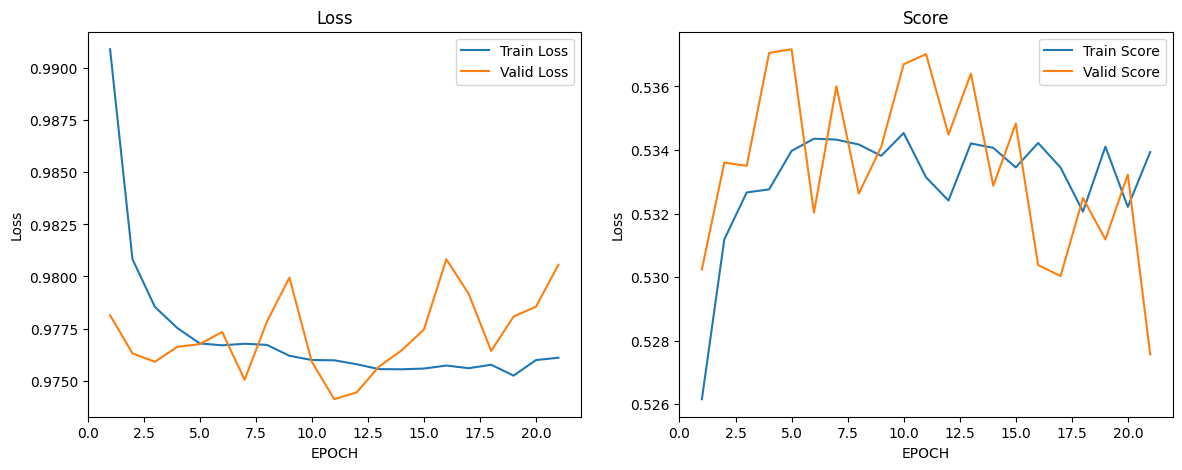

In [60]:
DrawPlot(result)
plt.show()